# 8. Create a Clean Dataset

## Analyze the Original HARRISON Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import ImageFile, Image

In [9]:
DATA_LIST = "../data_list_mixed.txt"
TAG_LIST = "../tag_list_mixed.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None,skip_blank_lines=False).fillna("")

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
num_images = target.shape[0]
target["google"] = [target.loc[i].filename[:6]=="google" for i in range(num_images)]

# Create tag counts matrix
vectorizer = CountVectorizer(binary=True)
y = vectorizer.fit_transform(hashtag["labels"])
hashtags = np.array(vectorizer.get_feature_names())
num_hashtags = hashtags.shape[0]
tag_counts_mat = pd.DataFrame(y.toarray(), columns=hashtags)

y_g = vectorizer.transform(hashtag["labels"].where(target.google).dropna())
tag_counts_g = pd.DataFrame(y_g.toarray(), columns=hashtags)

print(f"Number of images: {num_images}")
print(f"Number of hashtags: {num_hashtags}")
target.head()

Number of images: 217789
Number of hashtags: 997


,filename,labels,google
0,sea_image_50.jpg,sea instapic instagram trip travel,False
1,sea_image_1284.jpg,sea,False
2,sea_image_1122.jpg,sea love,False
3,sea_image_1679.jpg,beach sea trip island japan,False
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...,False


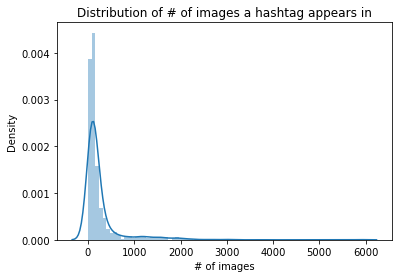

Avg. # of appearances: 261  
12 hashtags appear in 2000 images or more
792 hashtags appear in 261 images or less


In [3]:
tag_counts_h = tag_counts_mat.where(~target.google).dropna()
tag_counts_g = tag_counts_mat.where(target.google).dropna()

tag_counts = tag_counts_h.sum(axis=0).sort_values(ascending=True)
plt.title("Distribution of # of images a hashtag appears in")
sns.distplot(tag_counts, bins=75, axlabel="# of images")
plt.show()

avg = int(tag_counts.mean())
tag_counts.sort_values(ascending=False).head(10)
print(f"Avg. # of appearances: {avg}  ")

above2k = tag_counts.where(tag_counts>2000).dropna().shape[0]
print(f"{above2k} hashtags appear in 2000 images or more")

belowavg = tag_counts.where(tag_counts<avg).dropna().shape[0]
print(f"{belowavg} hashtags appear in {avg} images or less")


## Make All the Hashtags Equally Popular
We make all the hashtags appear in `avg` many images

In [10]:
add_counts = pd.DataFrame(columns=["add", "h", "g"])
new_target = pd.DataFrame()

n = 100
for i, tag in enumerate(hashtags):
    print(f"\r[{i+1}/{num_hashtags}] Adding HARRISON images for {tag}", end='')
    images_h = tag_counts_h.where(tag_counts_h[tag] > 0).dropna().sum(axis=1)

    if images_h.shape[0] < n:
        top_images_h = images_h.sort_values().index
        print(f"\r[{i+1}/{num_hashtags}] Adding Google images for {tag}", end='')
        images_g = tag_counts_g.where(tag_counts_g[tag] > 0).dropna().sum(axis=1)
        top_images_g = images_g.sort_values().index[:n-images_h.shape[0]]
        add = n - images_h.shape[0] - images_g.shape[0]
        if add > 0:
            add_counts.loc[tag] = [add, images_h.shape[0], images_g.shape[0]]
        top_images = list(top_images_h) + list(top_images_g)

    else:
        top_images = images_h.sort_values().index[:n]

    temp = pd.DataFrame()
    temp["filename"] = target["filename"].loc[top_images]
    temp["labels"] = tag
    new_target = pd.concat([new_target, temp])

print(f"\rDone: {new_target.shape[0]:.0f} images collected, {add_counts.sum()['add']:.0f} images to be added")

Done: 99513 images collected, 187 images to be added


In [11]:
add_counts.to_csv("8-add-counts-done.csv", header=False)
new_target.to_csv("8-new-target-done.csv", header=False, index=False)

In [15]:
new_target["filename"].to_csv("data_list_100.txt", header=False, index=False)
new_target["labels"].to_csv("tag_list_100.txt", header=False, index=False)